# # TVB only (multiscale) simulation

## tvb-multiscale toolbox:

https://github.com/the-virtual-brain/tvb-multiscale
 
For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@bih-charite.de

# An example of the simplest possible TVB only simulation

## Linear mean field model with 1 Excitatory population

For every region node $n\prime$ modelled as a mean-field node in TVB:

The rate R is given by:

$\dot{R_{n\prime}} = - \frac{1}{\tau}({\gamma R_{n\prime}}(t) + 
     G\sum_{{m\prime}\neq {n\prime}}C_{{m\prime}{n\prime}}R_{m\prime}(t-\tau_{{m\prime}{n\prime}})) + I_o$


TVB connectivity weights $C_{{m\prime}{n\prime}}$ are scaled per "region"

## Parameters:
 
- time constant $\tau = 100ms$ 
- linear coefficient $\gamma = -1.0$
- overall effective external input current $I_o = 0.0nA$ 
- global structural brain connectivity coupling constant $G$
- structural TVB connectivity weights $C_{{m\prime}{n\prime}}$ (${m\prime}->{n\prime}$)
- structural TVB connectivity delays $\tau_{{m\prime}{n\prime}}$  (${m\prime}->{n\prime}$)
 

In [1]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.core.config import Config, CONFIGURED

work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_nest")[0], "data")
outputs_path = os.path.join(work_path, "outputs/Linear")
config = Config(output_base=outputs_path)

config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config)

    
# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline

## 1. Prepare TVB simulator <br> (including structural data -minimally a TVB connectivity, region mean field model, integrator, monitors etc)


2023-09-20 17:42:34,630 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Region simulation with 68 ROI nodes
2023-09-20 17:42:34,631 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Memory requirement estimate: simulation will need about 2.2 MB
2023-09-20 17:42:34,632 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Preparing initial history of shape (880, 2, 68, 1) using model.initial()
2023-09-20 17:42:34,641 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Final initial history shape is (880, 2, 68, 1)
2023-09-20 17:42:34,642 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - initial state has shape (2, 68, 1)
2023-09-20 17:42:34,643 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Memory requirement census: simulation will need about 1.0 MB
2023-09-20 17:42:34,644 - WARNING - tvb_multiscale.core.tvb.cosimulator.cosimulator - There are no existing connections (i.e., with nonzero weights)!
Setting minimum delay to 1 integrator

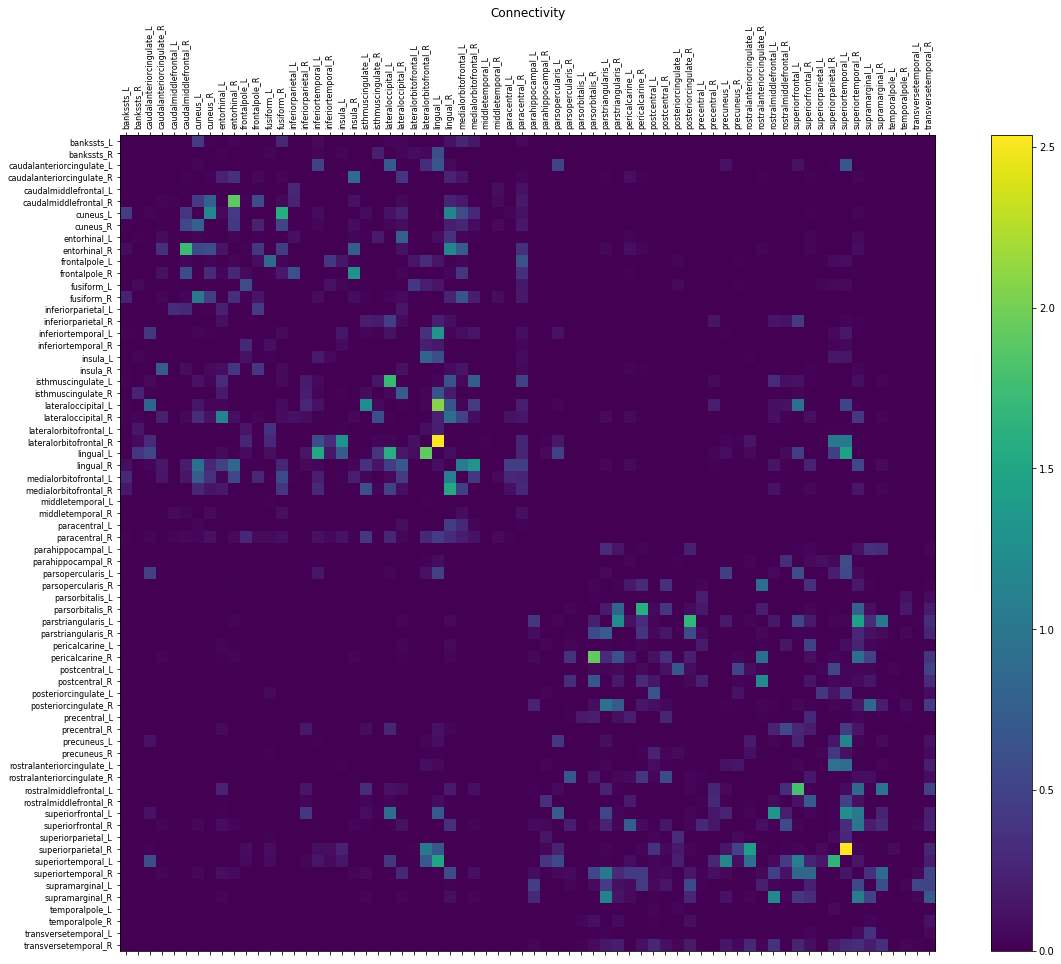

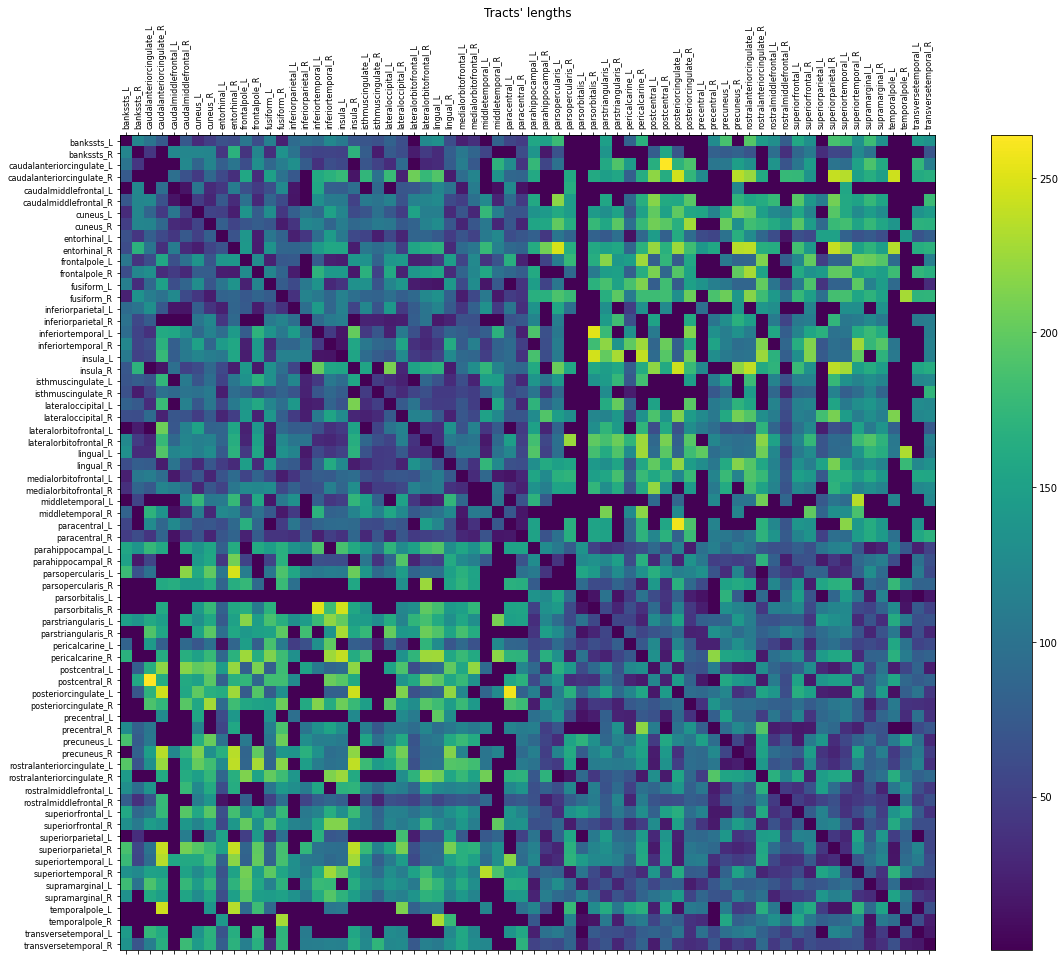

(<Figure size 1440x1080 with 2 Axes>,
 <AxesSubplot:title={'center':'Connectivity'}>,
 <Figure size 1440x1080 with 2 Axes>,
 <AxesSubplot:title={'center':"Tracts' lengths"}>)

In [2]:

from tvb_multiscale.core.tvb.cosimulator.cosimulator_builder import CoSimulatorBuilder
from tvb.datatypes.connectivity import Connectivity
from tvb_multiscale.core.tvb.cosimulator.models.linear import Linear, LinearRin


# Using the tvb-multdiscale simulator builder with default choices...
simulator_builder = CoSimulatorBuilder()
# Optionally modify the default configuration:
model_params = {
        "tau": np.array([100.0, ]),
        "gamma": np.array([-1.0, ]),
        "I_o": np.array([1.0, ]),
        "G":   np.array([2.0,])
    }
# Choose a model 
# Linear 
# or LinearRin to return input coupling rate Rin as state variable
simulator_builder.model = LinearRin(**model_params)  
# Mean field rate variables for plotting
# ["R"] for Linear  
# or ["R", "Rin"] for Linear Rin
tvb_rates_svs = ["R", "Rin"]  

simulator_builder.connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)

simulator = simulator_builder.build(**model_params)

simulation_length = 100.0


plotter.plot_tvb_connectivity(simulator.connectivity)

## 2. Configure simulator, simulate, gather results


In [3]:
# Configure the simulator interface...
# simulator.model.use_numba = False
simulator.configure()
# ...and simulate!
t = time.time()
results = simulator.run(simulation_length=simulation_length)
print("\nSimulated in %f secs!" % (time.time() - t))

2023-09-20 17:42:37,794 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Region simulation with 68 ROI nodes
2023-09-20 17:42:37,795 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Memory requirement estimate: simulation will need about 2.2 MB
2023-09-20 17:42:37,796 - ERROR - tvb_multiscale.core.tvb.cosimulator.cosimulator - Bad Simulator.integrator.noise.nsig shape: (1, 1, 1)
2023-09-20 17:42:37,797 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Preparing initial history of shape (880, 2, 68, 1) using model.initial()
2023-09-20 17:42:37,807 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Final initial history shape is (880, 2, 68, 1)
2023-09-20 17:42:37,808 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - initial state has shape (2, 68, 1)
2023-09-20 17:42:37,809 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Memory requirement census: simulation will need about 1.0 MB
2023-09-20 17:42:37,810 - WARNING - tvb_multiscale

In [4]:

try:
    from tvb_multiscale.core.tvb.io.h5_writer import H5Writer
    from examples.plot_write_results import write_RegionTimeSeriesXarray_to_h5
    writer = H5Writer()
except:
    writer = None
    
# Gather the results
t = results[0][0]
source = results[0][1]

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion

source_ts = TimeSeriesRegion(source, time=t,
               connectivity=simulator.connectivity,
               labels_ordering=["Time", "State Variable", "Region", "Neurons"],
               labels_dimensions=
                    {"State Variable": simulator.model.state_variables,
                     "Region": simulator.connectivity.region_labels.tolist()},
               sample_period=simulator.integrator.dt)
source_ts.configure()

# Write to file
if writer:
    write_RegionTimeSeriesXarray_to_h5(source_ts, writer,
                                       os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
source_ts 

2023-09-20 17:42:38,226 - INFO - tvb.storage.h5.encryption.data_encryption_handler - Cannot import syncrypto library.


In [5]:
# Separate mean field time series into different populations
from pandas import Series

from tvb_multiscale.core.utils.computations_utils import compute_tvb_spike_rate_corrs
mean_field = source_ts
tvb_rates = source_ts[:, tvb_rates_svs]
tvb_rates.title = "Region mean field rate time series"
tvb_spikes = None
    
tvb_corrs = compute_tvb_spike_rate_corrs(tvb_rates)
if writer is not None:
    write_RegionTimeSeriesXarray_to_h5(tvb_rates, writer,
                                       os.path.join(config.out.FOLDER_RES, tvb_rates.title.replace(" ", "_")) + ".h5",
                                       recursive=False)
    writer.write_object(tvb_corrs, path=os.path.join(config.out.FOLDER_RES, "TVB_corrs") + ".h5")

2023-09-20 17:42:38,682 - WARNING - tvb_multiscale.core.tvb.io.h5_writer - Failed to decompose group object: {'Pearson': <xarray.DataArray 'Mean field Pearson correlation' (State Variable_i: 2,
                                                    State Variable_j: 2,
                                                    Region_i: 68, Region_j: 68)>
array([[[[1.        , 0.89957146, 0.95603159, ..., 0.62957785,
          0.87346317, 0.88134954],
         [0.89957146, 1.        , 0.97002561, ..., 0.73831803,
          0.93696658, 0.9677916 ],
         [0.95603159, 0.97002561, 1.        , ..., 0.71518019,
          0.93463233, 0.95757394],
         ...,
         [0.62957785, 0.73831803, 0.71518019, ..., 1.        ,
          0.70343076, 0.72527449],
         [0.87346317, 0.93696658, 0.93463233, ..., 0.70343076,
          1.        , 0.94177267],
         [0.88134954, 0.9677916 , 0.95757394, ..., 0.72527449,
          0.94177267, 1.        ]],

        [[0.83298556, 0.72549716, 0.59066866, ..

/home/docker/.local/lib/python3.10/site-packages/xarray/plot/facetgrid.py:674: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self.fig.tight_layout()
/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:863: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  pyplot.gcf().tight_layout()


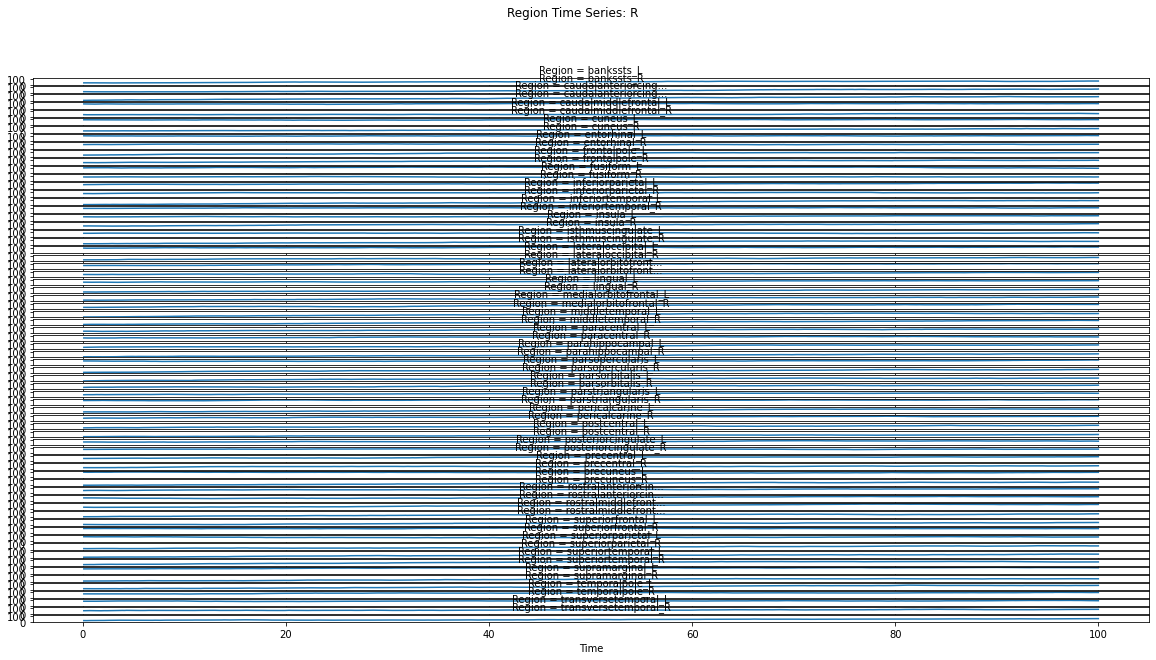

/home/docker/.local/lib/python3.10/site-packages/xarray/plot/facetgrid.py:674: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self.fig.tight_layout()
/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:863: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  pyplot.gcf().tight_layout()


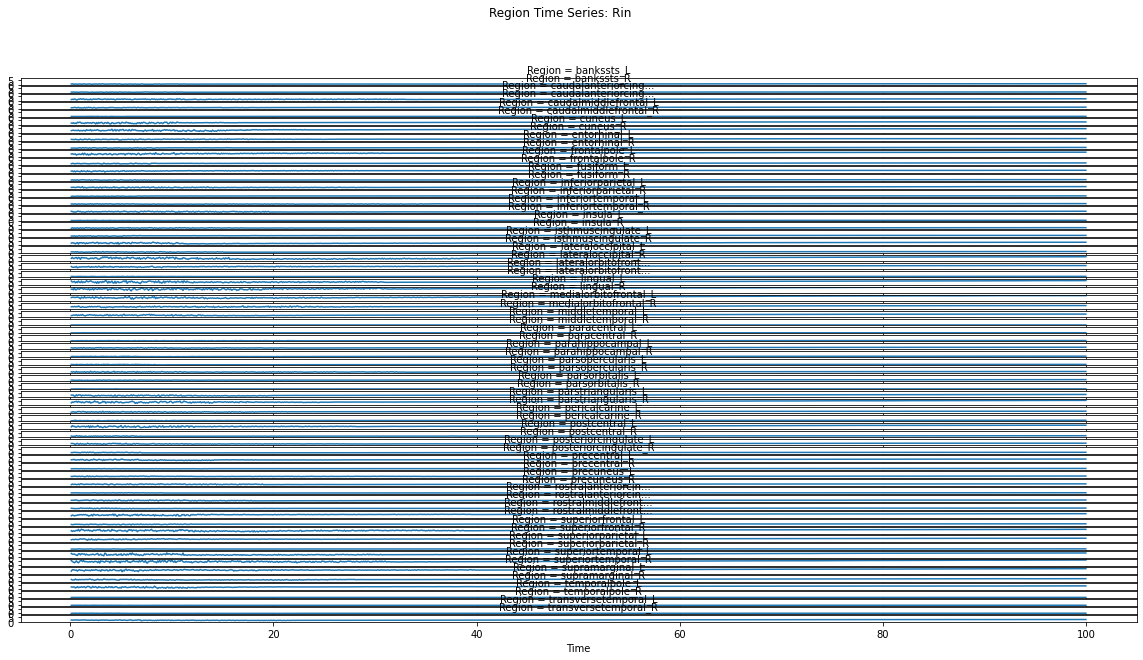

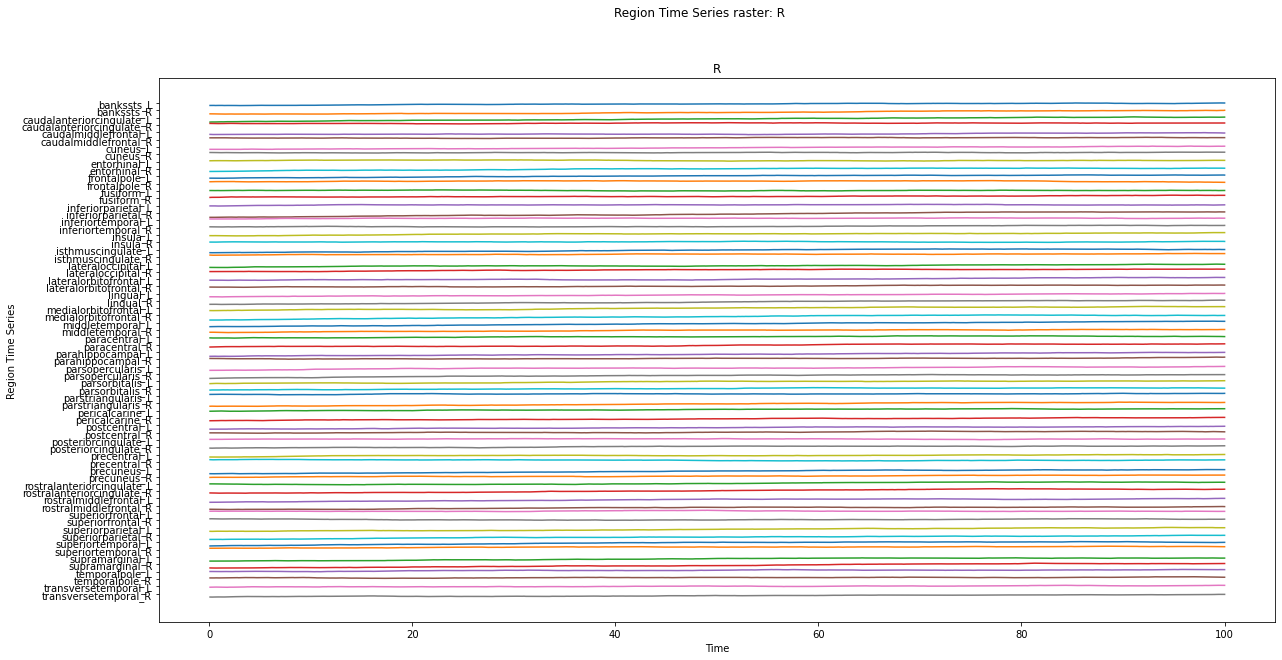

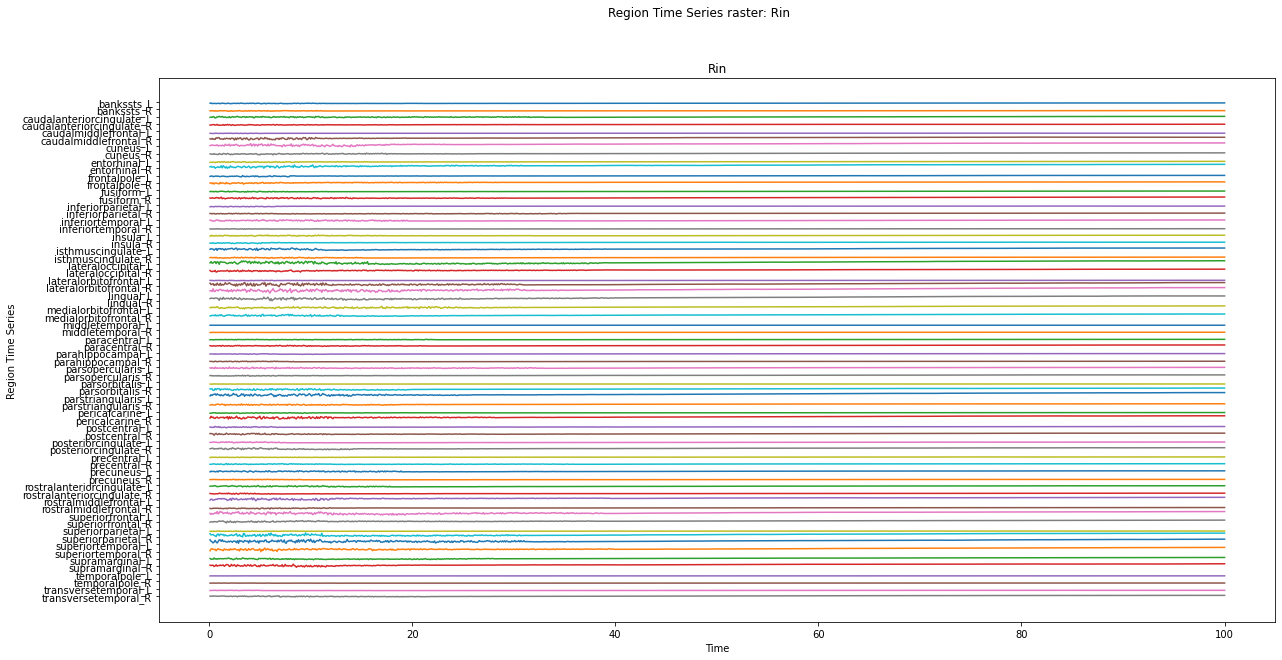

In [6]:
# For raster plot:
mean_field.plot_timeseries(plotter_config=plotter.config, per_variable=True, 
                           figsize=config.figures.NOTEBOOK_SIZE, add_legend=False)
if mean_field.number_of_labels > 9:
    mean_field.plot_raster(plotter_config=plotter.config, per_variable=True, 
                           figsize=config.figures.NOTEBOOK_SIZE, add_legend=False)

### Interactive time series plot

In [7]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)




# References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
The Virtual Brain: a simulator of primate brain network dynamics. <br>
Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
https://www.thevirtualbrain.org/tvb/zwei <br>
https://github.com/the-virtual-brain <br>
 
2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
The Virtual Brain integrates computational modeling  <br>
and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>